In [1]:
from torchvision.models import vgg16 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import Cityscapes_loader 
from torch.utils.data import Dataset, DataLoader
import time

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}

In [3]:
# Making VGG16 model
layers = []
in_channels = 3
batch_norm =False
for v in cfg['vgg16']:
    if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
            layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
            layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
model_encoder = nn.Sequential(*layers)
model_encoder = model_encoder.cuda()

In [4]:
#model_encoder1 = vgg16(pretrained=True)

In [5]:
#model_encoder1

In [6]:
#model_encoder

In [7]:
state_dict = torch.load('vgg16-397923af.pth') #state_dict['features.0.weight'] can access with key

In [8]:
#state_dict.keys(); # loading the pretrained model
#model_encoder.load_state_dict(state_dict)

In [9]:
for name, param in model_encoder.named_parameters():
    #print(name) # param.size
    model_encoder.state_dict()[name] = state_dict['features.'+name]
#for param in model_encoder.parameters():
#    print(param.requires_grad)
    

In [10]:
#model_encoder.state_dict()['0.weight']


In [11]:
batch_size, n_class, h, w = 10, 27, 160, 160

In [12]:
#input = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
#output_data = model_encoder(input)

In [13]:
#output_data.shape

In [14]:

def forward_vgg(x): 
    output = {}
    # get the output of each maxpooling layer (5 maxpool in VGG net)
    for idx in range(len(ranges['vgg16'])):
        for layer in range(ranges['vgg16'][idx][0], ranges['vgg16'][idx][1]):
            x = model_encoder[layer](x)
        output["x%d"%(idx+1)] = x
    return output

In [15]:
#out = forward_vgg(input)

In [16]:
#for idx in range(len(ranges['vgg16'])):
#    print(out["x%d"%(idx+1)].shape)

In [17]:
n_class = n_class
#pretrained_net = model_encoder
relu    = nn.ReLU(inplace=True).cuda()

deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1).cuda()
bn1     = nn.BatchNorm2d(512).cuda()

deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1).cuda()
bn2     = nn.BatchNorm2d(256).cuda()

deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1).cuda()
bn3     = nn.BatchNorm2d(128).cuda()

deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1).cuda()
bn4     = nn.BatchNorm2d(64).cuda()

deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1).cuda()
bn5     = nn.BatchNorm2d(32).cuda()

classifier = nn.Conv2d(32, n_class, kernel_size=1).cuda()

fcn_parameters = list(classifier.parameters())+ list(deconv1.parameters()) + list(bn1.parameters()) + list(deconv2.parameters()) + list(bn2.parameters()) + list(deconv3.parameters()) + list(bn3.parameters()) + list(deconv4.parameters()) + list(bn4.parameters()) + list(deconv5.parameters()) + list(bn5.parameters())

In [18]:
#[list(deconv5.parameters()) , list(deconv4.parameters())]

In [19]:
def forward_fcn(x):
    output = forward_vgg(x)
    #print(output)
    x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
    x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
    x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
    x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
    x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

    score = bn1(relu(deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
    score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
    score = bn2(relu(deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
    score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
    score = bn3(relu(deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
    score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
    score = bn4(relu(deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
    score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
    score = bn5(relu(deconv5(score)))  # size=(N, 32, x.H, x.W)
    score = classifier(score)
    return score



In [20]:
#criterion = nn.BCELoss().cuda()
#optimizer = optim.SGD(list(model_encoder.parameters()) + fcn_parameters , lr=1e-3, momentum=0.9)
n_class    = 27

batch_size = 6
epochs     = 500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = optim.RMSprop(list(model_encoder.parameters()) + fcn_parameters, lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs


In [21]:
#for name, param in bn1.named_parameters():
#    print(name) # param.size

In [22]:
#input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w)).cuda()
#y = torch.autograd.Variable(torch.zeros(batch_size, n_class, h, w), requires_grad=False).cuda()

In [23]:
#for iter in range(10):
#    optimizer.zero_grad()
#    output = forward_fcn(input)
#    output = nn.functional.sigmoid(output)
#    loss = criterion(output, y)from torch.utils.data import Dataset, DataLoader
#    loss.backward()
#    print("iter{}, loss {}".format(iter, loss.data))
#    optimizer.step()

In [24]:
batch_size = 6
root_dir  = "/home/ml/project/affordance_learning_code/datasets/CityScapeM/"
train_file = os.path.join(root_dir, "train/out.csv")
#val_file   = os.path.join(root_dir, "val.csv")
train_data = Cityscapes_loader.CityScapesDataset(csv_file=train_file, phase='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
#val_data = Cityscapes_loader.CityScapesDataset(csv_file=val_file, phase='val', flip_rate=0)
#val_loader = DataLoader(val_data, batch_size=1, num_workers=8)

In [29]:
use_gpu = True
def train():
    for epoch in range(epochs):
        ts = time.time()
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = (batch['X'].cuda())
                labels = (batch['Y'].cuda())
            else:
                inputs, labels = (batch['X']), (batch['Y'])

            outputs = forward_fcn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        #torch.save(forward_fcn, model_path)
        scheduler.step()

In [30]:
train()

epoch0, iter0, loss: 0.5820575952529907
epoch0, iter10, loss: 0.5855280756950378
epoch0, iter20, loss: 0.5785402655601501
epoch0, iter30, loss: 0.5881015658378601
epoch0, iter40, loss: 0.5851516723632812
epoch0, iter50, loss: 0.573849618434906
epoch0, iter60, loss: 0.5724303126335144
epoch0, iter70, loss: 0.5683090686798096
epoch0, iter80, loss: 0.5667131543159485
epoch0, iter90, loss: 0.56170654296875
epoch0, iter100, loss: 0.5631969571113586
epoch0, iter110, loss: 0.5598920583724976
epoch0, iter120, loss: 0.5573549866676331
epoch0, iter130, loss: 0.5569972395896912
epoch0, iter140, loss: 0.5571329593658447
epoch0, iter150, loss: 0.5497207641601562
epoch0, iter160, loss: 0.5482120513916016
epoch0, iter170, loss: 0.5411767363548279
epoch0, iter180, loss: 0.5427108407020569
epoch0, iter190, loss: 0.5470908880233765
epoch0, iter200, loss: 0.5400844216346741
epoch0, iter210, loss: 0.537427544593811
epoch0, iter220, loss: 0.5276960730552673
epoch0, iter230, loss: 0.5209786891937256
epoch0,

KeyboardInterrupt: 

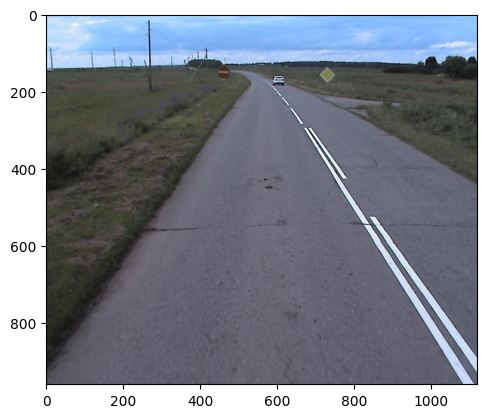

In [175]:
#a = mpimg.imread('/home/ml/project/affordance_learning_code/datasets/cityscape/leftImg8bit_trainvaltest/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png')
a = mpimg.imread('/home/ml/project/affordance_learning_code/img2.png')
#a = mpimg.imread('/home/ml/project/affordance_learning_code/im2.jpeg')
a = a[:960,:1120:]
#a = mpimg.imread('/home/ml/project/affordance_learning_code/datasets/cityscape/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000052_000019_leftImg8bit.png')
plt.imshow(a)

In [176]:
#for iter, batch in enumerate(train_loader):
#    inputs = (batch['X'].cuda())
#    labels = (batch['Y'].cuda())
#    print(inputs.shape)
#    print(labels.shape)

In [177]:
# reduce mean
img = a[:, :, ::-1]  # switch to BGR [h,w,3] switching 
img = np.transpose(img, (2, 0, 1)) # [3,h,w]
img[0] -= train_data.means[0]
img[1] -= train_data.means[1]
img[2] -= train_data.means[2]

# convert to tensor
img1 = torch.from_numpy(img.copy()).float()
img2 = img1.unsqueeze(0).cuda()

In [178]:
img2.shape

torch.Size([1, 3, 960, 1120])

In [179]:
outputs = forward_fcn(img2)
out1 = outputs.squeeze(0).cpu().detach().numpy()

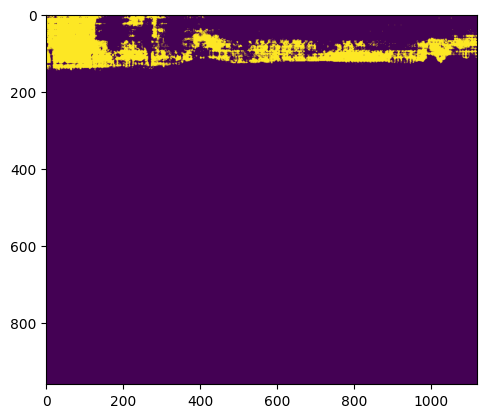

In [180]:
plt.imshow(out1[23]>0)

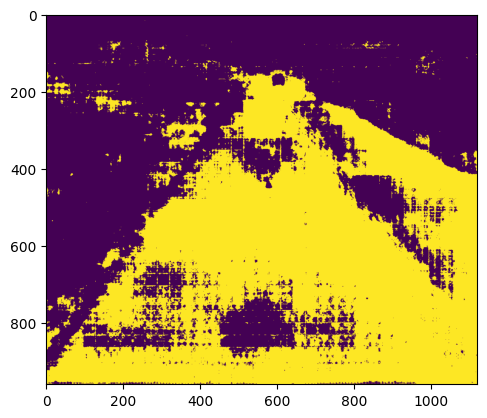

In [181]:
plt.imshow(out1[7]>-2)

In [58]:
yy

[3, 2, 1]